Data Integration and User Interface (Eliza)

In [1]:
# Import dependencies
import os
import pandas as pd
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel, AdamW, ViTForImageClassification, ViTFeatureExtractor
from diffusers import StableDiffusionPipeline, DDPMScheduler
import openai



In [2]:
# Load DiffusionDB Dataset using Hugging Face Datasets Library
dataset = load_dataset('poloclub/diffusiondb', 'large_random_1k')

In [3]:
# Display information about the dataset
dataset.data

{'train': MemoryMappedTable
 image: struct<bytes: binary, path: string>
   child 0, bytes: binary
   child 1, path: string
 prompt: string
 seed: uint32
 step: uint16
 cfg: float
 sampler: string
 width: uint16
 height: uint16
 user_name: string
 timestamp: timestamp[us, tz=UTC]
 image_nsfw: float
 prompt_nsfw: float
 ----
 image: [
   -- is_valid: all not null
   -- child 0 type: binary
 [null,null,null,null,null,...,null,null,null,null,null]
   -- child 1 type: string
 ["/Users/elizayoung/.cache/huggingface/datasets/downloads/extracted/9c35a7065cd3ec0972aff144da3f54a73bcb2c8a1c91f2751698f428d5f037f5/bf5b2c08-7919-4b3a-803a-a70480ed0735.webp","/Users/elizayoung/.cache/huggingface/datasets/downloads/extracted/9c35a7065cd3ec0972aff144da3f54a73bcb2c8a1c91f2751698f428d5f037f5/f4833174-f711-4dd0-a280-9df5b69528a6.webp","/Users/elizayoung/.cache/huggingface/datasets/downloads/extracted/9c35a7065cd3ec0972aff144da3f54a73bcb2c8a1c91f2751698f428d5f037f5/367ef631-b8f5-4b3b-9c6e-09bfa1d4fecb.webp

In [4]:
# Display first record of dataset
dataset['train'][0]

{'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=512x512>,
 'prompt': 'joe biden as a clown ',
 'seed': 449238076,
 'step': 50,
 'cfg': 7.0,
 'sampler': 'k_lms',
 'width': 512,
 'height': 512,
 'user_name': '94494c7e5c675384bd6036a921f9809f000c04a799eda9bd419fb0b1172c98de',
 'timestamp': datetime.datetime(2022, 8, 11, 16, 33, tzinfo=<UTC>),
 'image_nsfw': 0.03884477913379669,
 'prompt_nsfw': 0.9567571878433228}

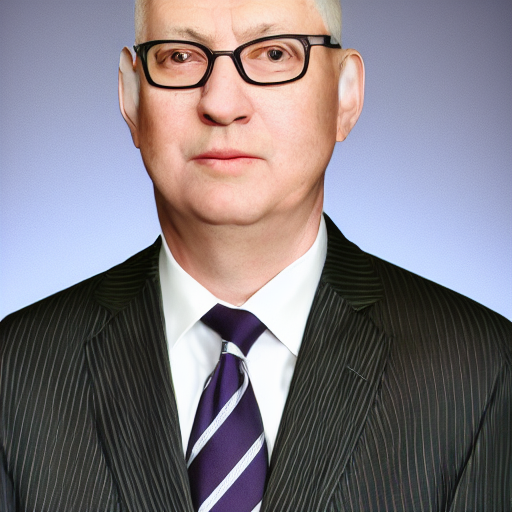

In [5]:
dataset['train'][0]['image']

In [6]:
# Preprocess Text Data
def preprocess_text(text):
    # Tokenization using simple split (or spaCY?)
    return text.lower().split()

dataset = dataset.map(lambda x: {'processed_text': 
                                 preprocess_text(x['prompt'])})

In [7]:
# Define Image Transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [8]:
# Initialize Models and Scheduler
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").text_model
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", use_auth_token=True)
scheduler = DDPMScheduler.from_config(pipe.scheduler.config)



/opt/anaconda3/envs/dev/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
# Define Image Transformations
#transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    #transforms.Lambda(lambda img: img.convert("RGBA")), 
    #transforms.ToTensor()
#])

In [16]:
# Set up data loader with transformations
def collate_fn(batch):
    texts = [item['processed_text'] for item in batch]
    images = [image_transforms(item['image']) for item in batch]
    return {'texts': texts, 'images': torch.stack(images)}


In [17]:
# Set up data loader
data_loader = DataLoader(dataset['train'], batch_size=8, shuffle=True, collate_fn=collate_fn)

In [19]:
# Training loop 
optimizer = torch.optim.Adam(pipe.unet.parameters(), lr=5e-5)
for epoch in range(5):
    for batch in data_loader:    
        inputs = processor(text=batch['texts'], return_tensors="pt", padding=True)
        encoder_hidden_states = text_encoder(**inputs).last_hidden_state
        #encoder_hidden_states = encoder_hidden_states.permute(0, 2, 1)

# Ensure encoder_hidden_states have the correct shape for the model
        if encoder_hidden_states.size(-1) != pipe.unet.config.encoder_hid_dim:
            raise ValueError(f"Encoder hidden states dimension {encoder_hidden_states.size(-1)} does not match expected {pipe.unet.config.encoder_hid_dim}")

        # Get a random timestep for each image in the batch
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch['images'].size(0),), device=batch['images'].device).long()
        
        # Forward pass through UNet with required inputs
        outputs = pipe.unet(batch['images'], timesteps, encoder_hidden_states).sample
        
        loss = ((outputs - batch['images']) ** 2).mean()
        loss.backward()
        optimizer.step()

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [24]:
# DALL-E 3 API Integration
# Store the API key in a variable.
OPENAI_API_KEY = os.environ("OPENAI_API_KEY")
#os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Initialize OpenAI client
client = openai.OpenAI(api_key=OPENAI_API_KEY)

# Function to generate image using DALL-E 3
def generate_image_with_dalle(prompt):
    response = client.Image.create(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1
    )
    return response['data'][0]['url']

TypeError: '_Environ' object is not callable

In [ ]:
# Prompt to generate image
prompt_example = "A scenic view of mountains in the fall"
dalle_image_url = generate_image_with_dalle(prompt_example)

print(f"Generated image URL: {dalle_image_url}")

Image Analysis and Evaluation (Tunji)

In [ ]:
# Import dependencies
import matplotlib.pyplot as plt

In [ ]:
# Image Analysis Module 

In [ ]:
# Visualization Example using Matplotlib

In [ ]:
# System Evaluation 

Interface Setup with Gradio (Tunji)

In [ ]:
# Setup Gradio
import gradio as gr
